<a href="https://colab.research.google.com/github/stevejerol/Image-Denoising-AE-MNIST/blob/main/MNIST_de_noising_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This version works for 28x28 dimension images

In [1]:
import torch.nn as nn
import matplotlib.pyplot as plt
import torch
import numpy as np
import torchvision
import pandas as pd


In [2]:
data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [3]:
from torchvision import transforms
from torch.utils.data import DataLoader,random_split

In [4]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

'''noise_factor = 0.2
x_train_noisy = X_train + noise_factor * numpy.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
x_test_noisy = X_test + noise_factor * numpy.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
x_train_noisy = numpy.clip(x_train_noisy, 0., 1.)
x_test_noisy = numpy.clip(x_test_noisy, 0., 1.)'''

In [5]:


train_transform = transforms.Compose([
    transforms.ToTensor()
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [6]:
s = train_data[0][0]

In [15]:
pool = nn.MaxPool2d(kernel_size=2)
pool(s).shape

torch.Size([1, 14, 14])

In [16]:
def add_noise(inputs,noise_factor=0.3):
     noisy = inputs+torch.randn_like(inputs) * noise_factor
     noisy = torch.clip(noisy,0.,1.)
     return noisy

In [166]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(1,8,kernel_size=2,stride=1,padding='same'), 
        nn.ReLU(),
        nn.Conv2d(8,16,kernel_size=2,stride=1,padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(16,24,kernel_size=2,stride=1,padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(24,32,kernel_size=3,stride=2,padding=0),
        nn.ReLU()
    )

    self.Flatten = nn.Flatten(start_dim=1)

    self.enc_lin = nn.Sequential(
        
        nn.Linear(3*3*32,128),
        nn.ReLU(),
        nn.Linear(128,8)
    )

    self.dec_lin =nn.Sequential(
        nn.Linear(8,128),
        nn.ReLU(),
        nn.Linear(128, 32*3*3),
        nn.ReLU(),
        nn.Unflatten(dim=1,unflattened_size =(32,3,3))
    )

    #self.pool = nn.MaxPool2d(kernel_size=2,padding=1)
    
    self.decoder = nn.Sequential(
        
        nn.ConvTranspose2d(32,24,kernel_size=3,stride=2),
        nn.ReLU(),
        nn.ConvTranspose2d(24,16,kernel_size=2,stride=2),
        nn.ReLU(),
        nn.ConvTranspose2d(16,8,kernel_size=2,stride=2),
        nn.ReLU(),
        nn.Conv2d(8,1,kernel_size=2,stride=1, padding='same'),
        nn.Sigmoid()
        
    )

  def forward(self,x):
    
    x = self.encoder(x)
    #print(x.shape)
    x=self.Flatten(x)
    #print(x.shape)
    x=self.enc_lin(x)
    #print(x.shape)
    x=self.dec_lin(x)
    
    #print(x.shape)
    x = self.decoder(x)
    #print(x.shape)
    
    
    return x


In [106]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [167]:
autoencoder_model = Encoder()
autoencoder_model.to(device)

Encoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(2, 2), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 24, kernel_size=(2, 2), stride=(1, 1), padding=same)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(24, 32, kernel_size=(3, 3), stride=(2, 2))
    (9): ReLU()
  )
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (enc_lin): Sequential(
    (0): Linear(in_features=288, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=8, bias=True)
  )
  (dec_lin): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU()
    (4): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  )
  (d

In [147]:
s= train_data[0][0]
#s1=autoencoder_model(s)

In [168]:
loss_func = nn.MSELoss()
optim = torch.optim.Adam(autoencoder_model.parameters(),lr=0.001)

In [123]:
loss_func2 = nn.MSELoss()
optim2 = torch.optim.Adam(autoencoder_model.parameters(),lr=0.001)
autoencoder_model2 = Encoder2(encoded_space_dim=4,fc2_input_dim=128)
autoencoder_model2.to(device)

Encoder2(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=2304, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=2304, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=

In [109]:
from tqdm import tqdm

In [110]:
samx,samy = next(iter(train_loader))
#output = autoencoder_model(samx)
#output.shape

In [111]:

def plot_ae_outputs_den(encoder,n=10,noise_factor=0.2):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}    
    for i in range(n):

      ax = plt.subplot(3,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0)
      image_noisy = add_noise(img,noise_factor)     
      image_noisy = image_noisy.to(device)

      encoder.eval()
      

      with torch.inference_mode():
         rec_img  = encoder(image_noisy)

      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(3, n, i + 1 + n)
      plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Corrupted images')

      ax = plt.subplot(3, n, i + 1 + n + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     
    plt.show()   

In [112]:
def train_step(model,dataloader,loss_fn,optimizer,noise_factor,device=device):
  model.train()
  train_loss=[]

  for X,y in dataloader:
    noisy_X = add_noise(X,noise_factor)
    X = X.to(device)
    noisy_X = noisy_X.to(device)
    output = model(noisy_X)
    loss = loss_fn(output, X)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #print(f'\t The batch loss is : {loss.data}')
    train_loss.append(loss.detach().cpu().numpy())
  
  return np.mean(train_loss)

In [103]:
def test_func(model,dataloader,loss_fn,noise_factor,device=device):
  model.eval()
  with torch.inference_mode():
    out=[]
    original=[]
    for X,_ in dataloader:
      noisy_X = add_noise(X,noise_factor)
      noisy_X = noisy_X.to(device)
      X = X.to(device)
      pred = model(noisy_X)
      
      out.append(pred)
      original.append(X)
    out = torch.cat(out)
    original = torch.cat(original)

    val_loss = loss_fn(out,original)
  return val_loss.data

  0%|          | 0/20 [00:00<?, ?it/s]


 training loss =  0.09731783717870712	 validation loss = 0.06778737902641296


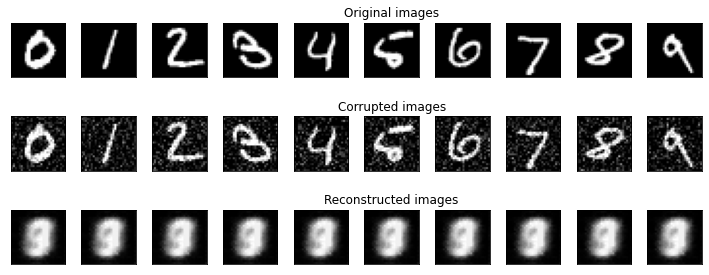

  5%|▌         | 1/20 [00:07<02:28,  7.84s/it]


 training loss =  0.06731393188238144	 validation loss = 0.06691186875104904


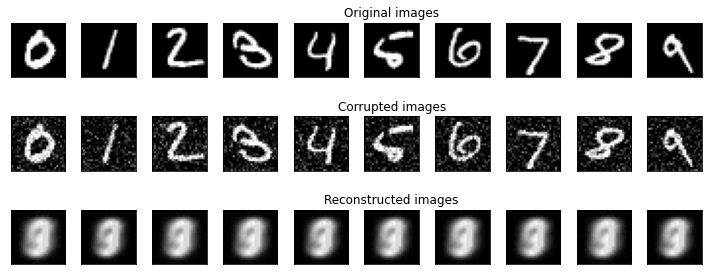

 10%|█         | 2/20 [00:15<02:19,  7.72s/it]


 training loss =  0.05950499698519707	 validation loss = 0.0492875836789608


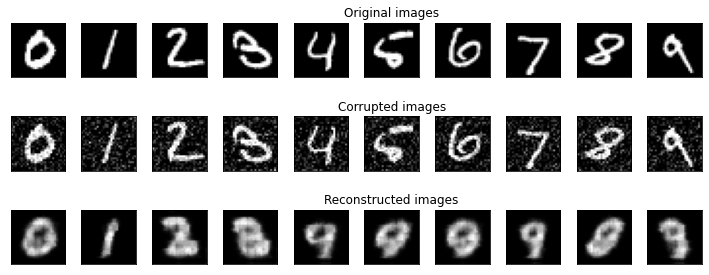

 15%|█▌        | 3/20 [00:23<02:11,  7.71s/it]


 training loss =  0.04330760985612869	 validation loss = 0.03620065376162529


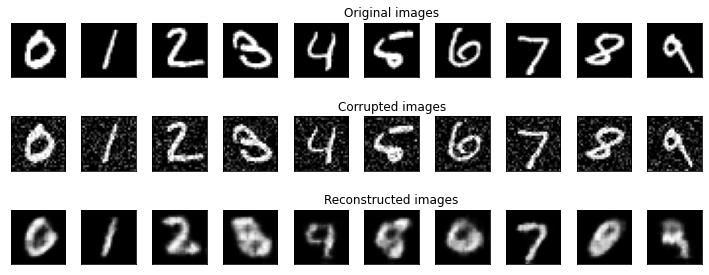

 20%|██        | 4/20 [00:30<02:03,  7.75s/it]


 training loss =  0.03252783417701721	 validation loss = 0.03063833713531494


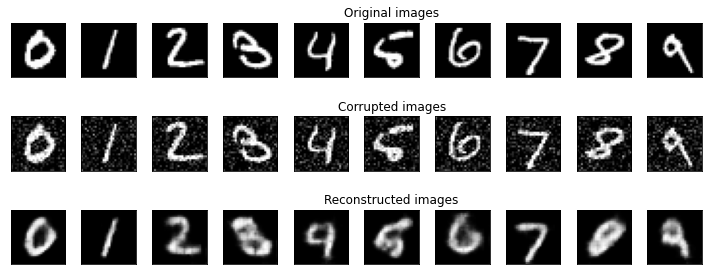

 25%|██▌       | 5/20 [00:38<01:56,  7.74s/it]


 training loss =  0.02939075604081154	 validation loss = 0.028722155839204788


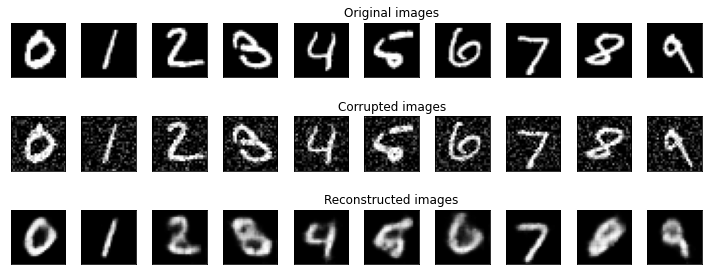

 30%|███       | 6/20 [00:46<01:47,  7.69s/it]


 training loss =  0.02735285647213459	 validation loss = 0.026588309556245804


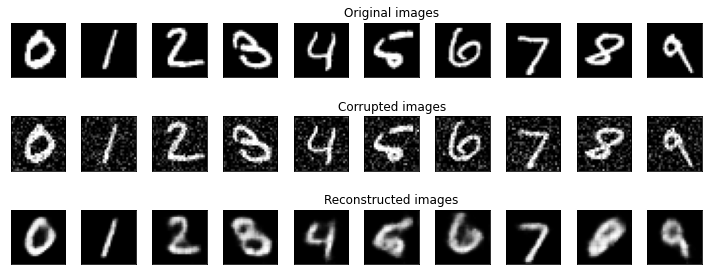

 35%|███▌      | 7/20 [00:53<01:39,  7.69s/it]


 training loss =  0.02584134228527546	 validation loss = 0.025351185351610184


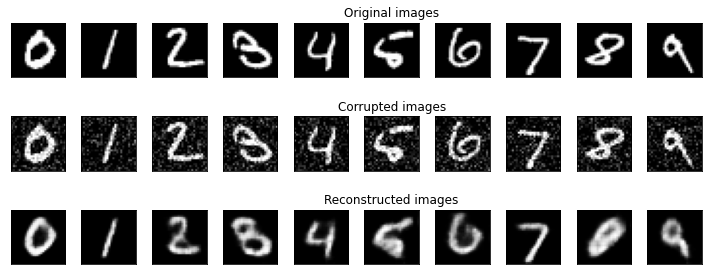

 40%|████      | 8/20 [01:01<01:32,  7.71s/it]


 training loss =  0.02486804686486721	 validation loss = 0.024553557857871056


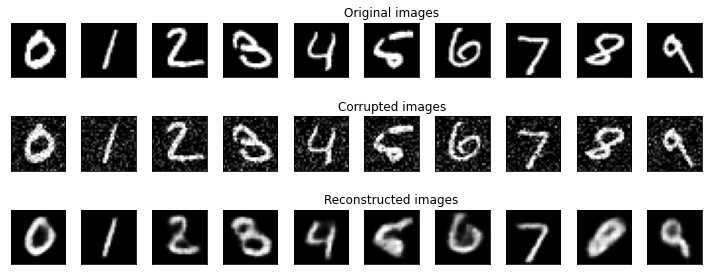

 45%|████▌     | 9/20 [01:09<01:24,  7.72s/it]


 training loss =  0.024137740954756737	 validation loss = 0.023832077160477638


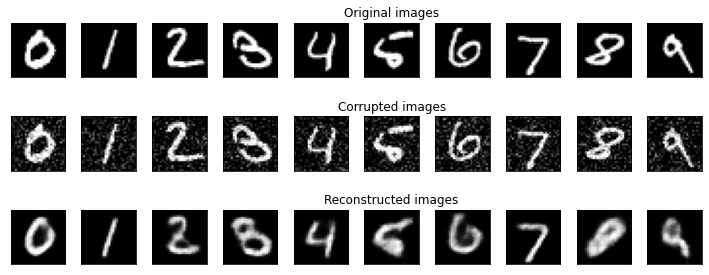

 50%|█████     | 10/20 [01:17<01:17,  7.71s/it]


 training loss =  0.023506712168455124	 validation loss = 0.02328547276556492


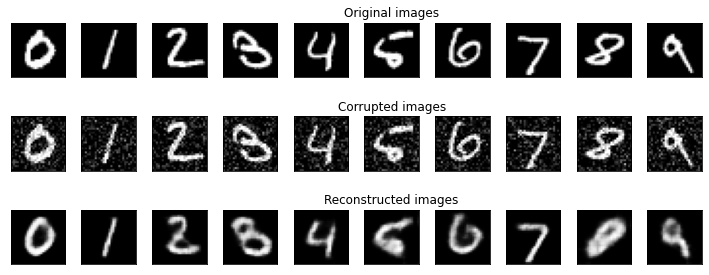

 55%|█████▌    | 11/20 [01:24<01:09,  7.72s/it]


 training loss =  0.022953448817133904	 validation loss = 0.02277674898505211


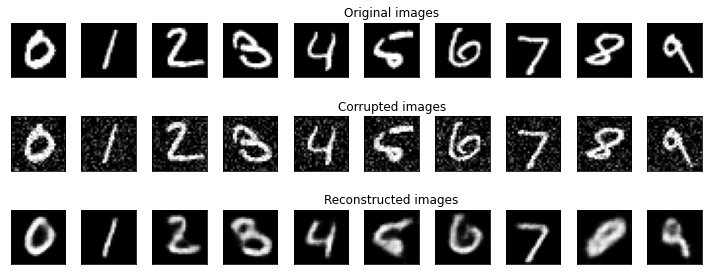

 60%|██████    | 12/20 [01:32<01:01,  7.73s/it]


 training loss =  0.02246052958071232	 validation loss = 0.022304926067590714


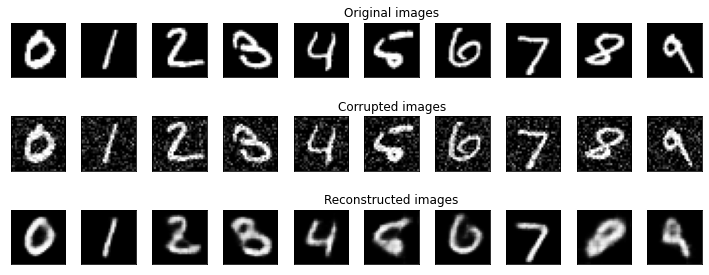

 65%|██████▌   | 13/20 [01:40<00:53,  7.68s/it]


 training loss =  0.022002963349223137	 validation loss = 0.02189282327890396


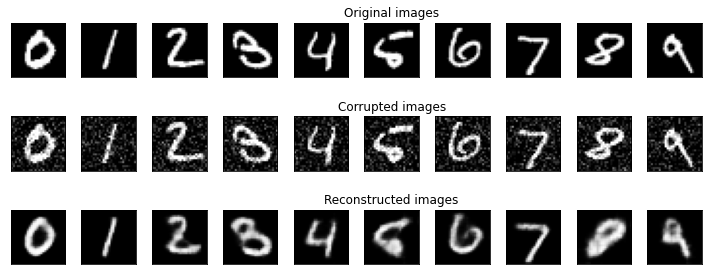

 70%|███████   | 14/20 [01:48<00:46,  7.71s/it]


 training loss =  0.021606015041470528	 validation loss = 0.021580016240477562


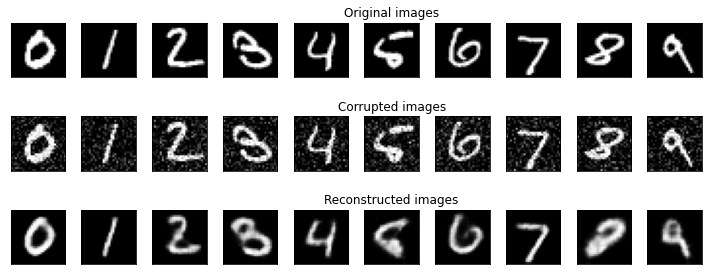

 75%|███████▌  | 15/20 [01:55<00:38,  7.72s/it]


 training loss =  0.021230194717645645	 validation loss = 0.02121807262301445


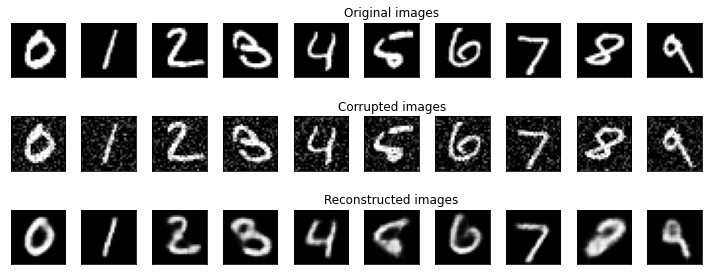

 80%|████████  | 16/20 [02:03<00:30,  7.72s/it]


 training loss =  0.02089923620223999	 validation loss = 0.020887212827801704


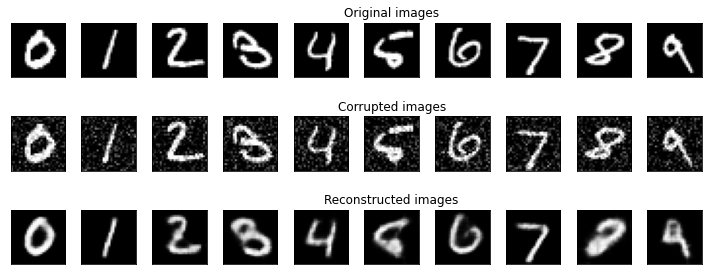

 85%|████████▌ | 17/20 [02:11<00:23,  7.68s/it]


 training loss =  0.02060798369348049	 validation loss = 0.020743517205119133


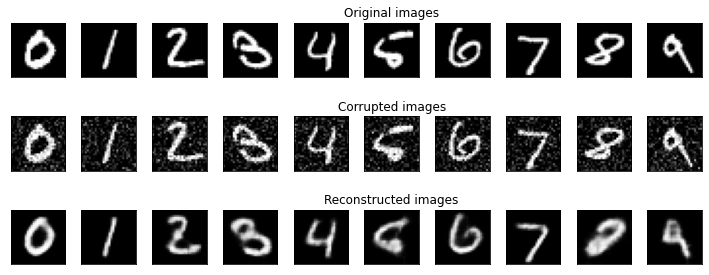

 90%|█████████ | 18/20 [02:18<00:15,  7.70s/it]


 training loss =  0.020341334864497185	 validation loss = 0.020378809422254562


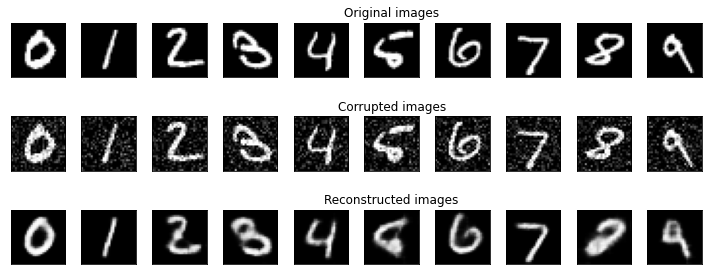

 95%|█████████▌| 19/20 [02:26<00:07,  7.70s/it]


 training loss =  0.020089080557227135	 validation loss = 0.020316995680332184


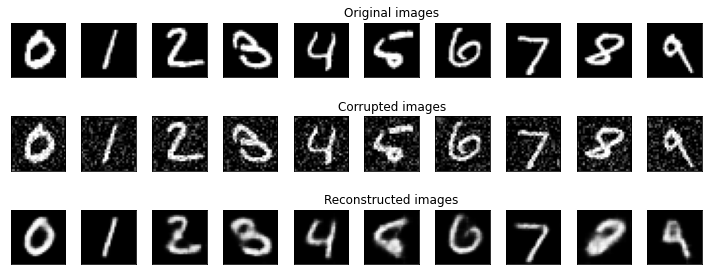

100%|██████████| 20/20 [02:34<00:00,  7.71s/it]


In [169]:
EPOCHS = 20
history={'train_loss':[],'val_loss':[]}
for epoch in tqdm(range(EPOCHS)):
  
  train_loss=train_step(model=autoencoder_model,
             dataloader=train_loader,
             loss_fn=loss_func,
             optimizer=optim,
             noise_factor=0.2, 
             device=device)
  val_loss = test_func(model=autoencoder_model,
                       dataloader=valid_loader,
                       loss_fn= loss_func,
                       noise_factor=0.2,
                       device=device)
  history['train_loss'].append(train_loss)
  history['val_loss'].append(val_loss)
  print(f'\n training loss =  {train_loss}\t validation loss = {val_loss}')
  plot_ae_outputs_den(autoencoder_model , n=10, noise_factor=0.2)

  